In [71]:
import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib
import pandas as pd
import numpy as np
import ipympl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from config_local import helpers

from sklearn.linear_model import Lasso, LogisticRegression, ElasticNet, Ridge

from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

%matplotlib inline

hp = helpers()

In [2]:
_data_path = hp.get_data_path()
print(_data_path)

/media/jan/TOSHIBA EXT/SMHDD_22/data/


In [3]:
phenotypic_df = pd.read_csv(_data_path + "NYU_phenotypic.csv")
phenotypic_df.head()

,ScanDir ID,Site,Gender,Age,Handedness,DX,Secondary Dx,ADHD Measure,ADHD Index,Inattentive,...,Full4 IQ,Med Status,QC_Rest_1,QC_Rest_2,QC_Rest_3,QC_Rest_4,QC_Anatomical_1,QC_Anatomical_2,Fold,Partition
0,1000804,5,1.0,7.29,0.83,0,NaN,2,40,41,...,109,1,1.0,0.0,NaN,NaN,1.0,NaN,4.0,train
1,1023964,5,1.0,8.29,0.57,3,NaN,2,60,56,...,123,-999,1.0,0.0,NaN,NaN,1.0,1.0,3.0,train
2,1057962,5,1.0,8.78,-999.00,1,NaN,2,77,81,...,129,1,1.0,NaN,NaN,NaN,1.0,0.0,1.0,train
3,1099481,5,0.0,8.04,0.50,1,NaN,2,86,82,...,116,1,1.0,0.0,NaN,NaN,1.0,1.0,2.0,train
4,1127915,5,0.0,12.44,0.21,0,NaN,2,42,43,...,124,1,1.0,1.0,NaN,NaN,1.0,1.0,4.0,train


In [4]:
phenotypic_df = pd.read_csv(_data_path + "NYU_phenotypic.csv").fillna(-999)
dic = {}

for i, row in phenotypic_df.iterrows():
    
    id = str(row['ScanDir ID']).zfill(7)
    fold = int(row['Fold'])
    part = row['Partition']

    if fold != -999:
        file = _data_path + f"{part}/fold{fold}/wmean_mrda{id}_session_1_rest_1.nii.gz"
        img = nib.load(file)
        data = img.get_fdata()
        y = row['DX']
        y_bin = int(y>=1)
        dic[id] = {"img":img, "data":data, "dx":y, "dx_bin":y_bin, "part":part, "fold":fold, "data_reduced":data[12:-12, 12:-12 , 12:-12]}

In [5]:
orig_shape = dic["0010001"]["data"].shape

In [6]:
def train_loader(dic, i, pca=False):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if ((subj["part"]=="train") & (subj["fold"]!=i)):
            X_train.append(subj['data'].reshape(-1))
            y_train.append(subj['dx_bin'])
                
        if ((subj["part"]=="train") & (subj["fold"]==i)):
            X_val.append(subj['data'].reshape(-1))
            y_val.append(subj['dx_bin'])
            
    if pca:
        transformer = MiniBatchSparsePCA(n_components=10,
                                         batch_size=3,
                                         random_state=42)
        transformer.fit(X_train)
        X_train = transformer.transform(X_train)
        X_val = transformer.transform(X_val)

    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [39]:
X_train, y_train, _, _ = train_loader(dic, 1)
eps=1e-3
f1_scores = []
coefs = []
lam = 0.74923

for fold in range(1, 6):

    X_train, y_train, X_val, y_val = train_loader(dic, fold)

    clf = Lasso(alpha=lam,
                random_state=42,
                max_iter=7000).fit(X_train, y_train)
    y_pred = np.round(clf.predict(X_val))
    
    score = f1_score(y_val, y_pred, average="weighted")
    f1_scores.append(score)
    coefs.append(clf.coef_)

mean_coefs = np.mean(coefs, axis=0)


In [40]:
img_data = mean_coefs.reshape(orig_shape)

In [41]:
len(mean_coefs[mean_coefs!=0])

287

<AxesSubplot: ylabel='Count'>

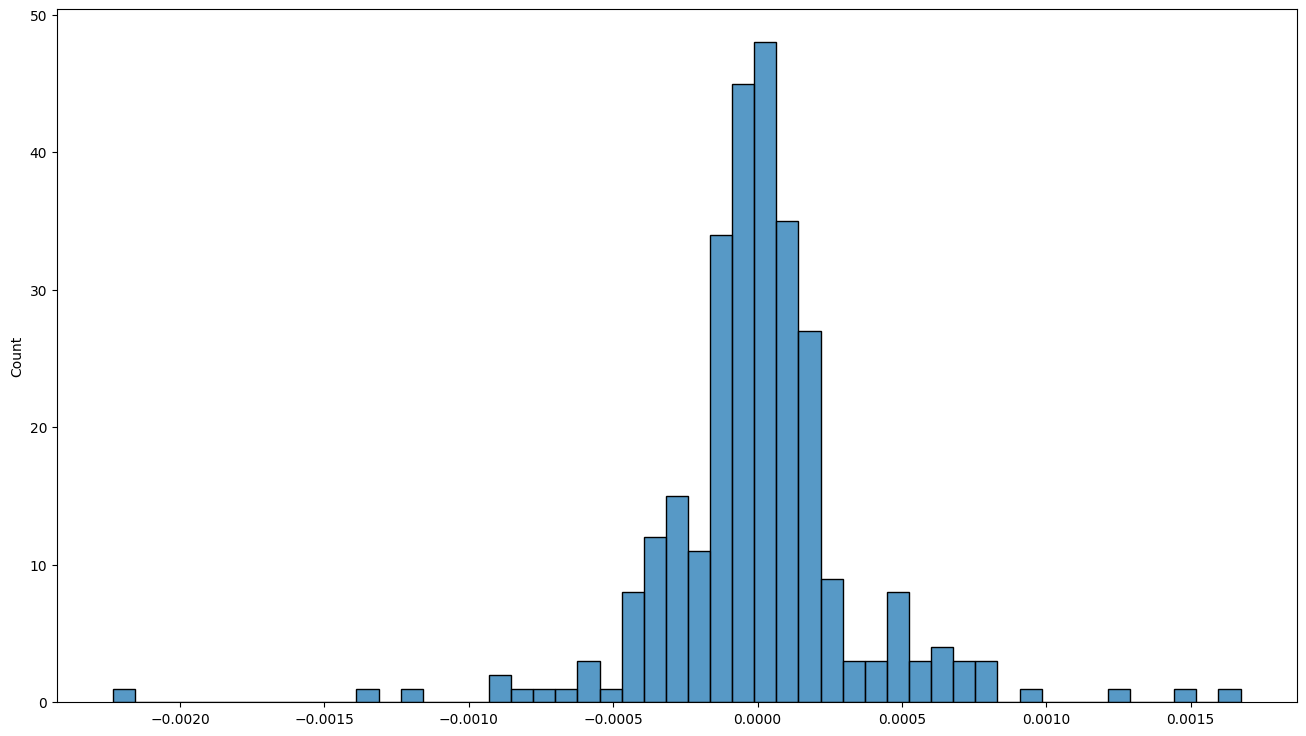

In [28]:
import seaborn as sns

fig , ax = plt.subplots(figsize=(16, 9))
sns.histplot(mean_coefs[mean_coefs!=0], ax=ax)

ValueError: num must be 1 <= num <= 40, not 41

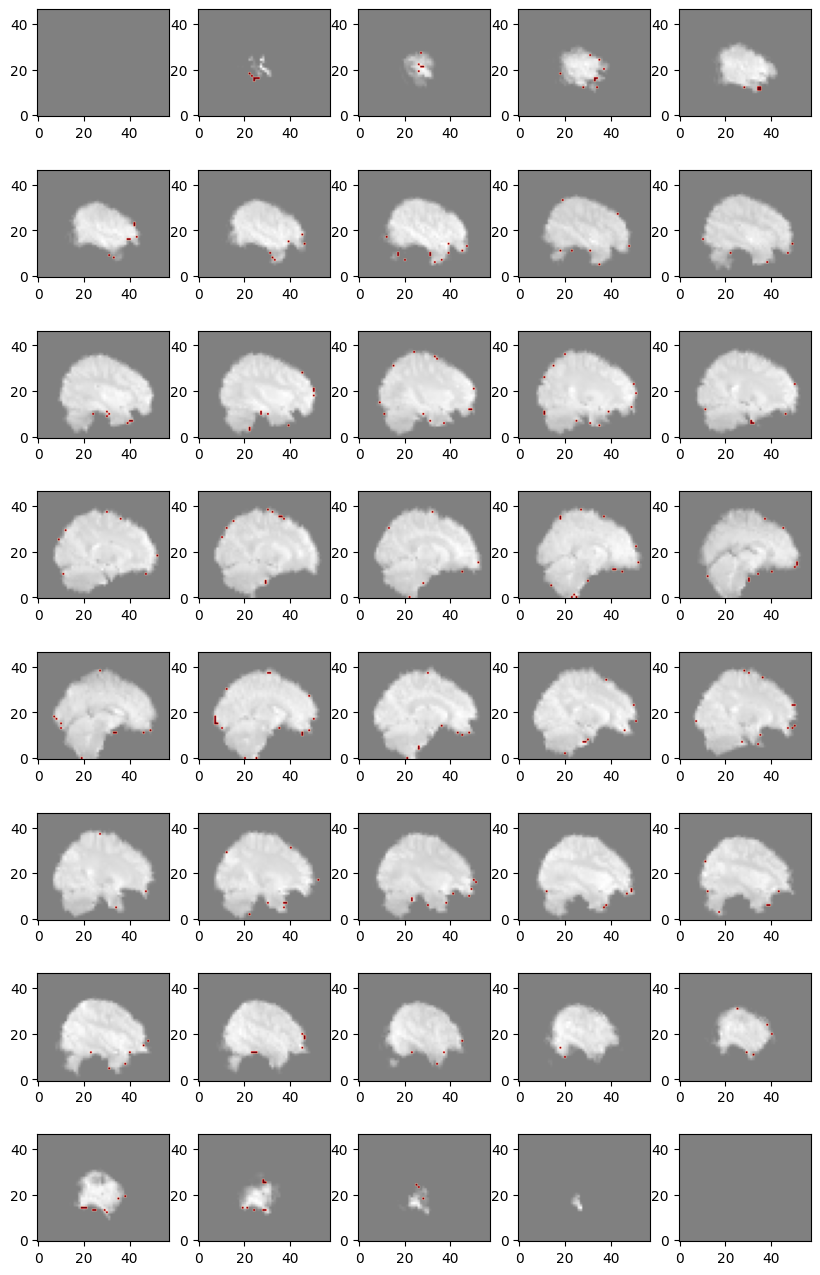

In [47]:
plt.figure(figsize=(10, 16))
plt.subplots_adjust(hspace=0.5)

# loop through the length of tickers and keep track of index
for i in range(img_data.shape[2]):
    
    coef_mask = 1.0*(img_data[i+5, :, :]!=0).T

    ax = plt.subplot(8, 5, i + 1)
    ax.imshow(dic["0010001"]["data"][i+5, :, :].T, origin='lower', cmap='gray', alpha=0.5)
    ax.imshow(coef_mask, origin='lower', cmap="Reds", alpha=coef_mask)
    ax.set_xlabel("")
    
plt.tight_layout()
plt.show()

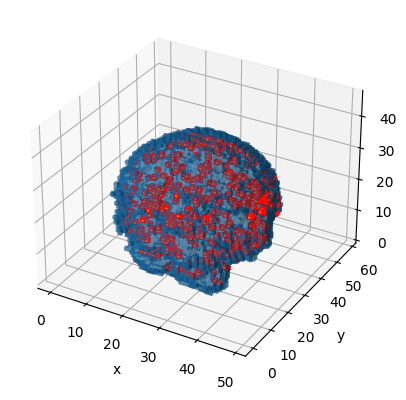

In [35]:
def make_ax(grid=False):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(dic["0010001"]["data"], alpha=0.5)
ax.voxels(img_data, edgecolors='red', shade=False)
plt.show()

# Ridge

In [72]:
X_train, y_train, _, _ = train_loader(dic, 1)
eps=1e-3
f1_scores = []
coefs = []
lam = 27185.88243

for fold in range(1, 6):

    X_train, y_train, X_val, y_val = train_loader(dic, fold)

    clf = Ridge(alpha=lam,
                random_state=42,
                max_iter=7000).fit(X_train, y_train)
    y_pred = np.round(clf.predict(X_val))
    
    score = f1_score(y_val, y_pred, average="weighted")
    f1_scores.append(score)
    coefs.append(clf.coef_)

mean_coefs = np.mean(coefs, axis=0)


In [73]:
img_data = mean_coefs.reshape(orig_shape)

In [74]:
len(mean_coefs[mean_coefs!=0])

54825

ValueError: num must be 1 <= num <= 40, not 41

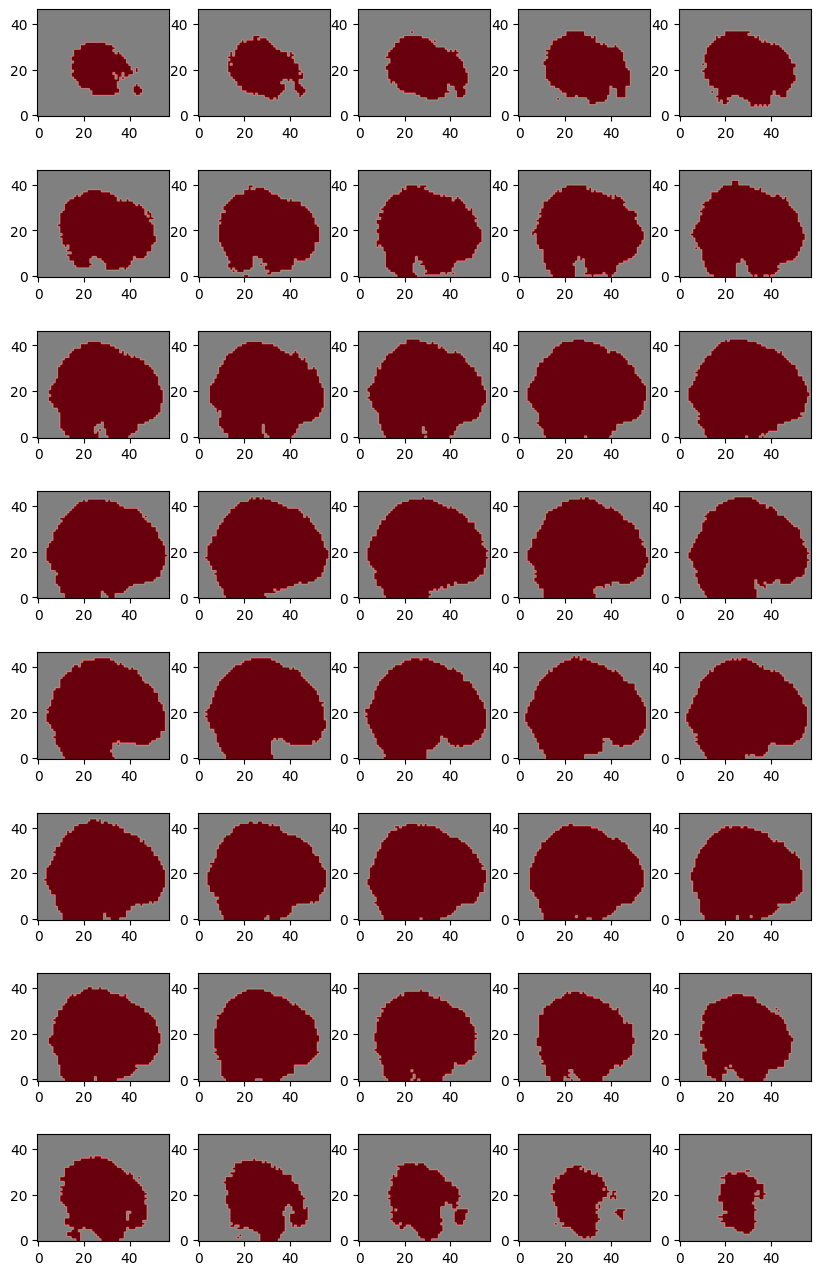

In [76]:
plt.figure(figsize=(10, 16))
plt.subplots_adjust(hspace=0.5)

# loop through the length of tickers and keep track of index
for i in range(img_data.shape[2]):
    
    coef_mask = 1.0*(img_data[i+5, :, :]!=0).T

    ax = plt.subplot(8, 5, i + 1)
    ax.imshow(dic["0010001"]["data"][i+5, :, :].T, origin='lower', cmap='gray', alpha=0.5)
    ax.imshow(coef_mask, origin='lower', cmap="Reds", alpha=coef_mask)
    ax.set_xlabel("")
    
plt.tight_layout()
plt.show()

# Elastic Net

In [52]:
alpha = 0.1
lam = 6.95527

X_train, y_train, _, _ = train_loader(dic, 1)
eps=1e-3
f1_scores = []
coefs = []

for fold in range(1, 6):

    X_train, y_train, X_val, y_val = train_loader(dic, fold)

    clf = ElasticNet(alpha=lam,
                    l1_ratio=alpha,
                    random_state=42,
                    max_iter=10000).fit(X_train, y_train)
    y_pred = np.round(clf.predict(X_val))
    
    score = f1_score(y_val, y_pred, average="weighted")
    f1_scores.append(score)
    coefs.append(clf.coef_)

mean_coefs = np.mean(coefs, axis=0)


In [53]:
len(mean_coefs[mean_coefs!=0])

315

ValueError: num must be 1 <= num <= 40, not 41

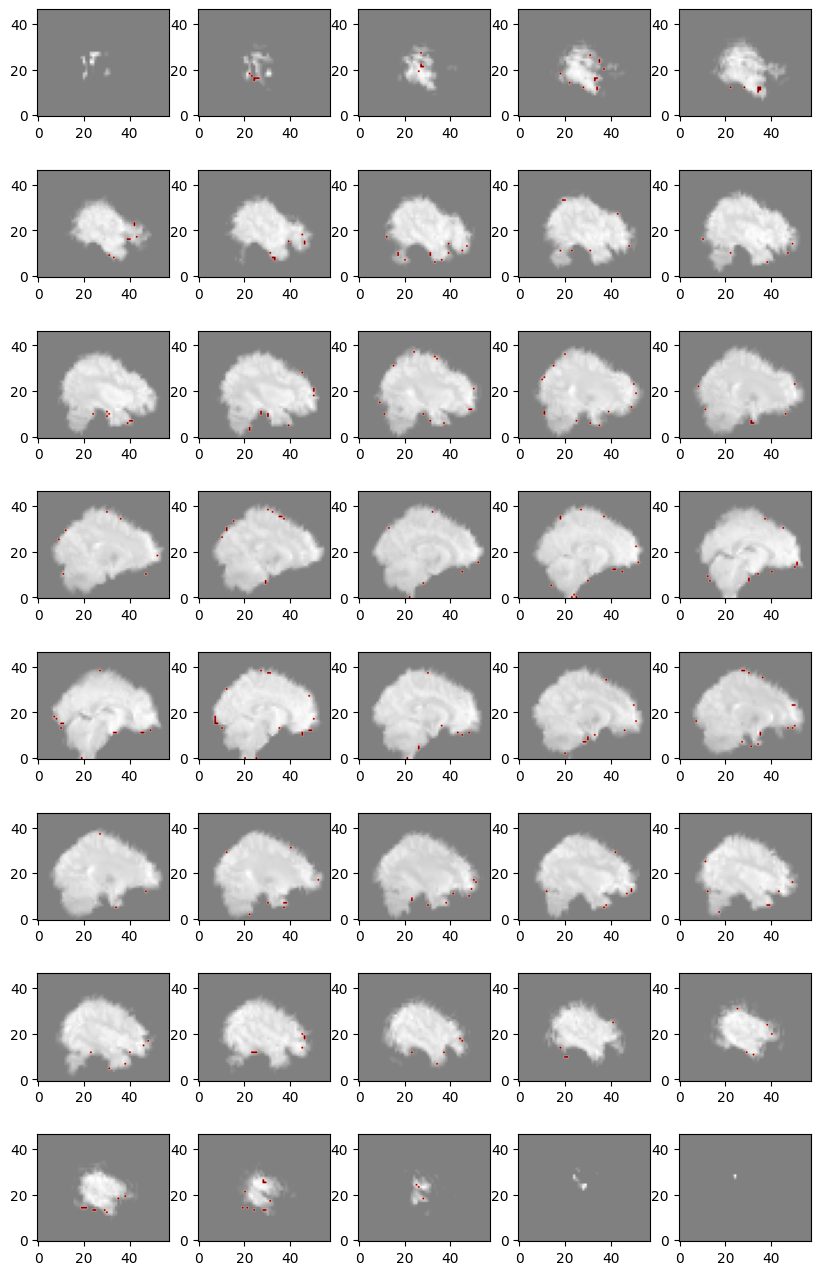

In [54]:
img_data = mean_coefs.reshape(orig_shape)

plt.figure(figsize=(10, 16))
plt.subplots_adjust(hspace=0.5)

# loop through the length of tickers and keep track of index
for i in range(img_data.shape[0]):
    
    # coef_mask = 1.0*(img_data[:, :, i]!=0).T
    coef_mask = 1.0*(img_data[i+5, :, :]!=0).T

    ax = plt.subplot(8, 5, i + 1)
    # ax.imshow(dic["0010001"]["data"][:, :, i].T, origin='lower', cmap='gray', alpha=0.5)
    ax.imshow(dic["0010002"]["data"][i+5, :, :].T, origin='lower', cmap='gray', alpha=0.5)
    ax.imshow(coef_mask, origin='lower', cmap="Reds", alpha=coef_mask)
    ax.set_xlabel("")
    
plt.tight_layout()
plt.show()

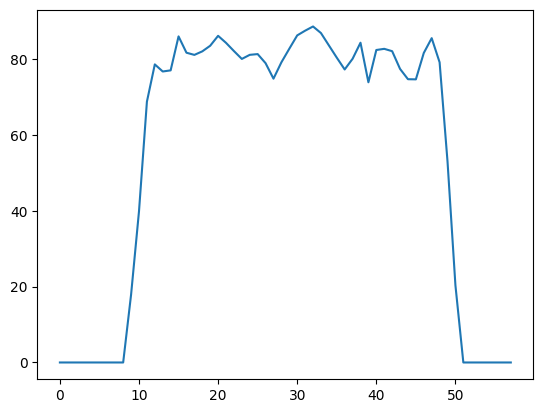

In [19]:
plt.plot(dic["0010002"]["data"][25, :, 25])

## Fused Lasso


In [55]:
with open(_data_path + "fused_lasso_3000.json") as file:
    fused_lasso = json.load(file)

In [56]:
# get betas from last run (lowest lambda)
fs = [row[-1] for row in fused_lasso["beta"]]

In [69]:
sum(np.array(fs)!=0)

12

In [57]:
img_fused_lasso = np.array(fs).reshape(25, 34, 23)

In [63]:
fused_lasso["lambda"][-1]

29.6019

In [58]:
img_fused_lasso_full = np.pad(img_fused_lasso, pad_width=[(12, 12), (12, 12) , (12, 12)])

ValueError: num must be 1 <= num <= 40, not 41

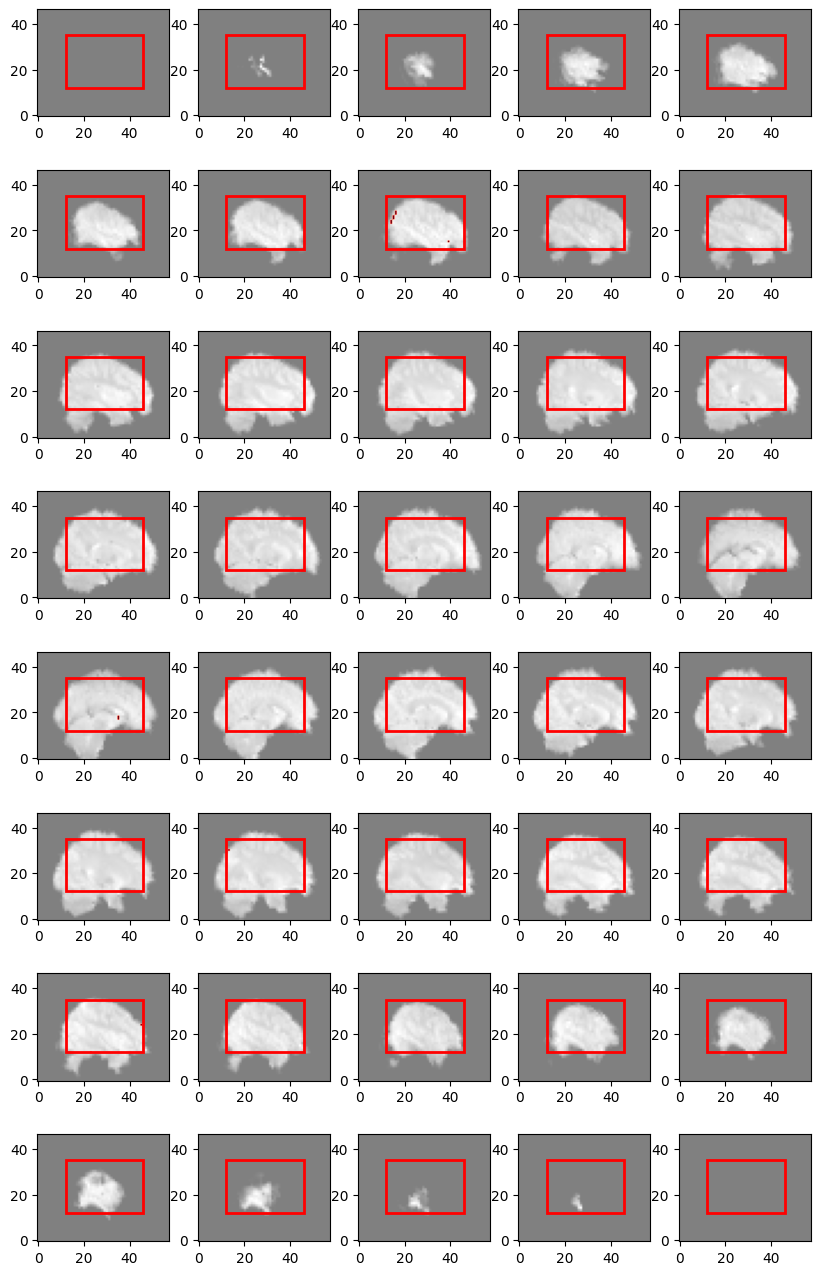

In [70]:
plt.figure(figsize=(10, 16))
plt.subplots_adjust(hspace=0.5)

# loop through the length of tickers and keep track of index
for i in range(img_fused_lasso_full.shape[2]):
    
    coef_mask = 1.0*(img_fused_lasso_full[i+5, :, :]!=0).T

    ax = plt.subplot(8, 5, i + 1)
    ax.imshow(dic["0010001"]["data"][i+5, :, :].T, origin='lower', cmap='gray', alpha=0.5)
    ax.imshow(coef_mask, origin='lower', cmap="Reds", alpha=coef_mask)
    rect = patches.Rectangle((12, 12), img_fused_lasso.shape[1], img_fused_lasso.shape[2], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.set_xlabel("")
plt.tight_layout()
plt.show()